In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb
df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev) 

2.1.2+cu121
True
NVIDIA A10


In [3]:
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

In [4]:
obs.size()

torch.Size([1, 501])

In [5]:
#### Number of data points
#S = 500

# time inteval
delta = 1

#n = int(S/delta)
n = 500
y0 = 0
# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

501


In [6]:
# Data import
# Default : cuda
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/Comparison/Comparison2/Comparison2_sim" + str(j) +".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output_raw = torch.cat(output_raw, dim = 0)

X_raw = X_raw.to(device)
output_raw = output_raw.to(device)

X_raw = X_raw.to("cpu")

a = torch.quantile(X_raw, .000001, 0)
a = torch.reshape(a, (1, a.size()[0]))
b = torch.quantile(X_raw, .999999, 0)
b = torch.reshape(b, (1, b.size()[0]))

output = []
output.append(output_raw[:,0])
output.append(output_raw[:,1])
output.append(output_raw[:,2])
output.append(torch.log(output_raw[:,3]))
output.append(torch.log(output_raw[:,4]))
output = torch.column_stack(output)

X = torch.clone((X_raw - a) / (b - a))
torch.set_default_device(dev)
X = X.to(dev)
output = output.to(dev)



L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'Compare2_MOUJ_sigma.pt'
path = F"./{model_save_name}"

torch.Size([450000, 44]) torch.Size([40000, 44]) torch.Size([10000, 44])


In [7]:
torch.mean(output_raw,0)

tensor([ 1.2505, -0.0014,  0.4996,  0.2001,  0.9994], device='cuda:0')

In [8]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.4223, device='cuda:0') tensor(-2.1331) tensor(177690.2500)
1 tensor(1.4208, device='cuda:0') tensor(-2.1295) tensor(177228.5781)
2 tensor(1.6040, device='cuda:0') tensor(-1.4691e-05) tensor(73014368.)
3 tensor(1.0842, device='cuda:0') tensor(2.0025e-07) tensor(2.5195e+08)
4 tensor(1.0843, device='cuda:0') tensor(1.3025e-06) tensor(2.5199e+08)
5 tensor(1.1826, device='cuda:0') tensor(0.0075) tensor(198002.0156)
6 tensor(1.1278, device='cuda:0') tensor(9.0846e-07) tensor(3.5791e+08)
7 tensor(1.0894, device='cuda:0') tensor(-61.9647) tensor(1.9041e+14)
8 tensor(1.5055, device='cuda:0') tensor(8.9186e-12) tensor(2.1369e+18)
9 tensor(1.3068, device='cuda:0') tensor(-0.0021) tensor(3.8325e+14)
10 tensor(1.4198, device='cuda:0') tensor(5.7682e-12) tensor(1.4464e+18)
11 tensor(1.0016, device='cuda:0') tensor(-0.0933) tensor(0.7453)
12 tensor(1.2345, device='cuda:0') tensor(-1.8922) tensor(117294.5312)
13 tensor(1., device='cuda:0') tensor(0.9900) tensor(0.9980)
14 tensor(1., device=

In [9]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [10]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [11]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.4632, 0.0651, 0.1900, 0.0269, 0.0267], device='cuda:0')


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 0.997423  [   64/450000]
train_loss: 0.145186  [64064/450000]
train_loss: 0.130585  [128064/450000]
train_loss: 0.151974  [192064/450000]
train_loss: 0.125986  [256064/450000]
train_loss: 0.154803  [320064/450000]
train_loss: 0.156126  [384064/450000]
train_loss: 0.117519  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.148619 val_loss 0.143618
train_loss: 0.114797  [   64/450000]
train_loss: 0.114811  [64064/450000]
train_loss: 0.136203  [128064/450000]
train_loss: 0.141514  [192064/450000]
train_loss: 0.116885  [256064/450000]
train_loss: 0.138414  [320064/450000]
train_loss: 0.144534  [384064/450000]
train_loss: 0.114640  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.136589 val_loss 0.136414
train_loss: 0.121447  [   64/450000]
train_loss: 0.109882  [64064/450000]
train_loss: 0.132407  [128064/450000]
train_loss: 0.144637  [192064/450000]
train_loss: 0.117007  [256064/450000]
train_loss: 0.130326  [320064/450000]
train_loss: 0

In [78]:
print(np.min(val_error_plt))

0.04723338037729263


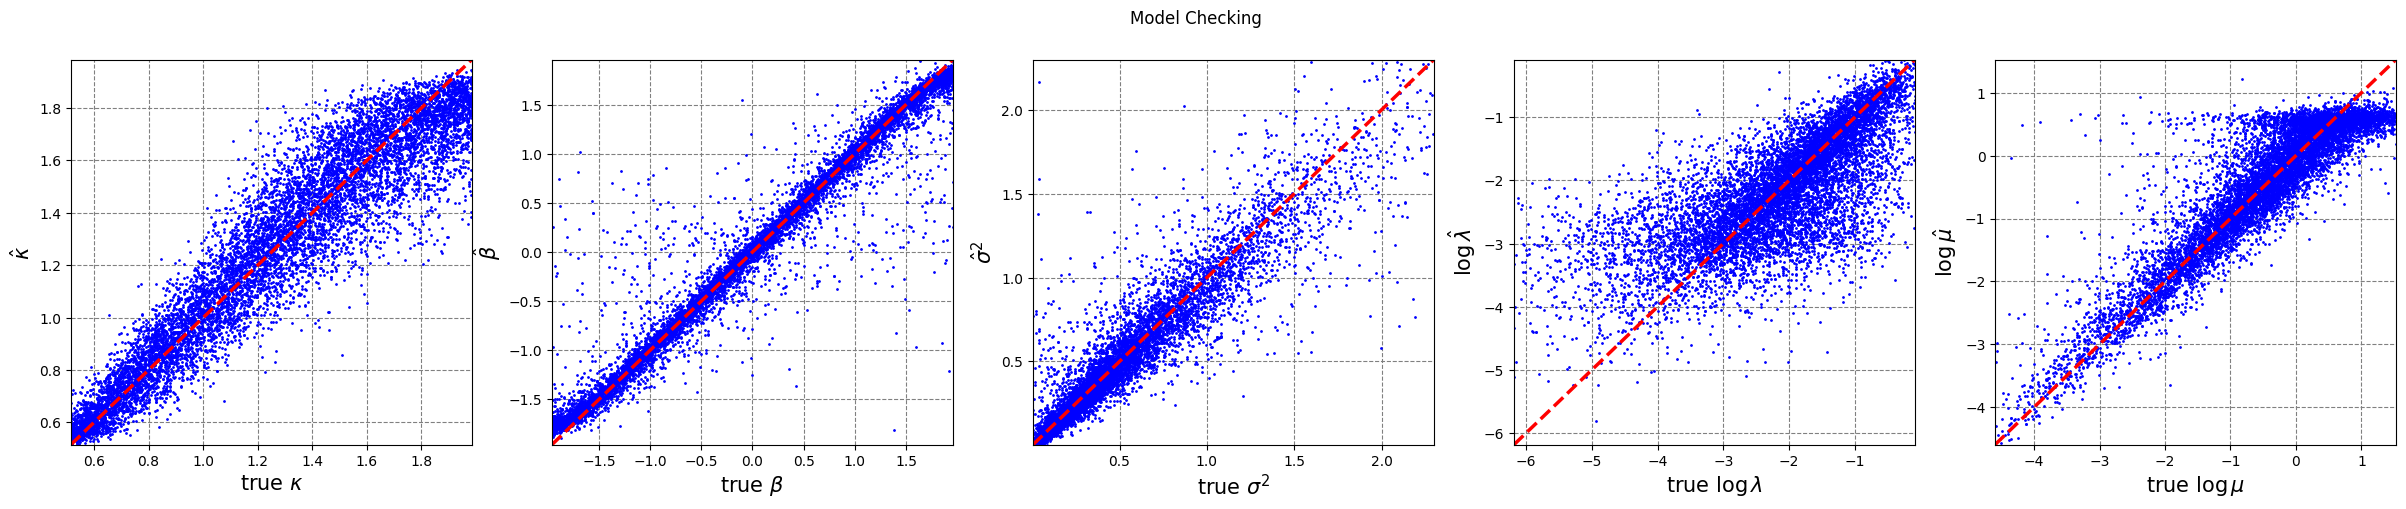

In [12]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\log\lambda$', r'true $\log\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\log\hat{\lambda}$', r'$\log\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    

plt.show()

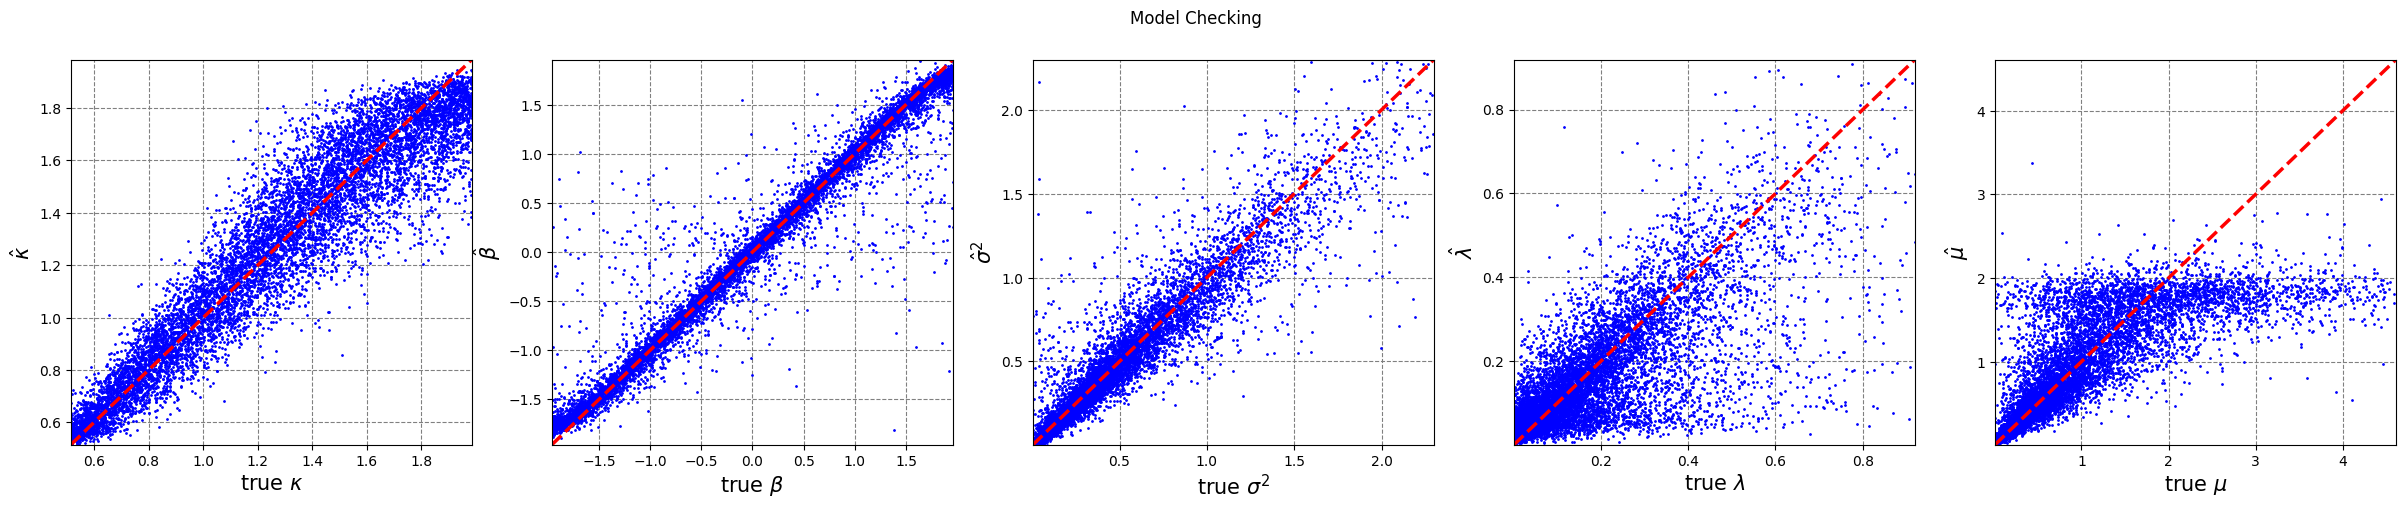

In [13]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\hat{\lambda}$', r'$\hat{\mu}$']


exp_ind = [3, 4]

with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()

for i in exp_ind:
    lim_left[i] = np.exp(lim_left[i])
    lim_right[i] = np.exp(lim_right[i])
    

fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    if i in exp_ind:
        axes[i].scatter(torch.exp(y_test[:,i]), np.exp(tmp1), marker='o', color='b', s= 1)
    else:
        axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    
plt.show()

In [14]:
torch.set_default_device("cpu")
net = net.to("cpu")
df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

obs = MROUJ_summary2(obs)

obs = torch.clone((obs - a) / (b - a))
print(net(obs))
print(torch.exp(net(obs)))


tensor([[ 0.9364,  0.0237,  0.8178, -2.1466, -0.1426]],
       grad_fn=<AddmmBackward0>)
tensor([[2.5507, 1.0240, 2.2656, 0.1169, 0.8671]], grad_fn=<ExpBackward0>)


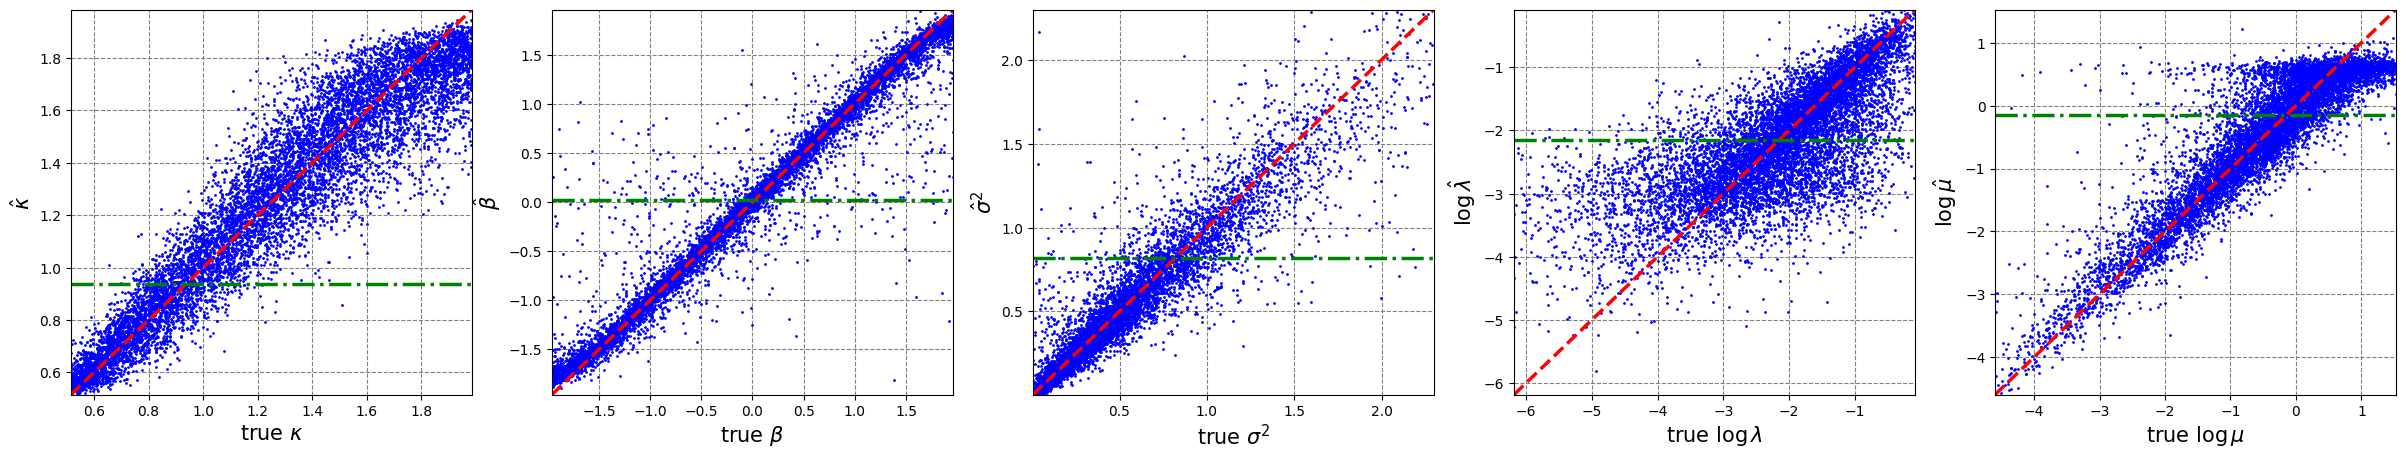

In [15]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\log\lambda$', r'true $\log\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\log\hat{\lambda}$', r'$\log\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()

est = np.concatenate(net(obs).detach().cpu().numpy())

fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
#fig.suptitle('Learning Checking', fontsize = 40)

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    axes[i].axhline(y = est[i], color = 'green', linestyle = '-.', linewidth = 2.5) 
    

plt.show()

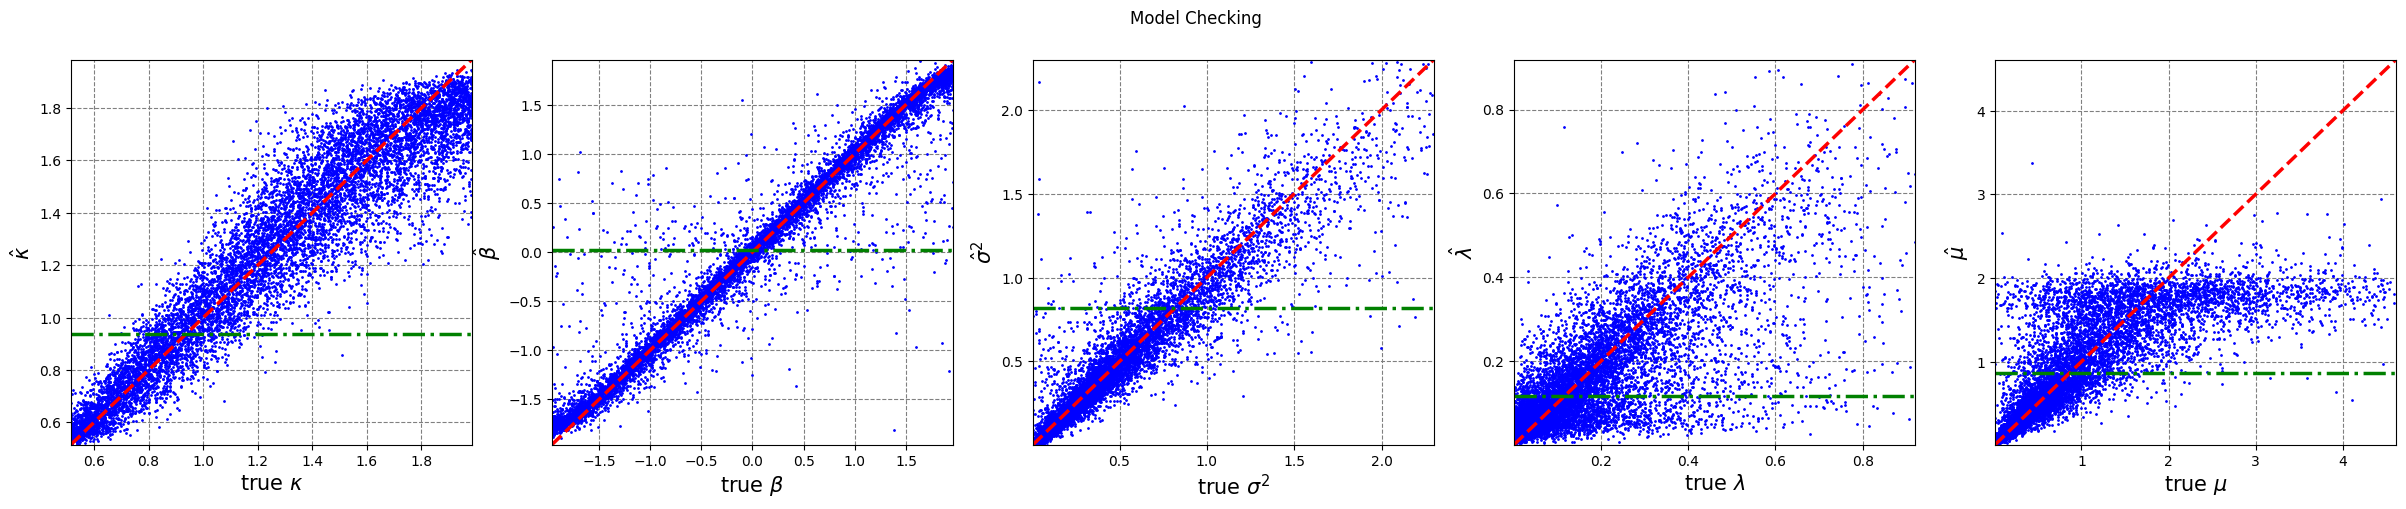

In [16]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\hat{\lambda}$', r'$\hat{\mu}$']


exp_ind = [3, 4]

with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()

est = np.concatenate(net(obs).detach().cpu().numpy())

for i in exp_ind:
    lim_left[i] = np.exp(lim_left[i])
    lim_right[i] = np.exp(lim_right[i])
    est[i] = np.exp(est[i])
    
    

fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    if i in exp_ind:
        axes[i].scatter(torch.exp(y_test[:,i]), np.exp(tmp1), marker='o', color='b', s= 1)
    else:
        axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    axes[i].axhline(y = est[i], color = 'green', linestyle = '-.', linewidth = 2.5) 
plt.show()

In [17]:
path_cal = "../../../depot_hyun/hyun/Comparison/Comparison2/Comparison2_sim"

X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))


output_cal = []
output_cal.append(y_cal[:,0])
output_cal.append(y_cal[:,1])
output_cal.append(y_cal[:,2])
output_cal.append(torch.log(y_cal[:,3]))
output_cal.append(torch.log(y_cal[:,4]))

output_cal = torch.column_stack(output_cal)

In [16]:
net.eval()
results3 = conf_inf_sd(obs, X_cal, output_cal, net, .03)

train_loss: 0.138456  [   64/73500]
train_loss: 0.129960  [ 6464/73500]
train_loss: 0.125228  [12864/73500]
train_loss: 0.122924  [19264/73500]
train_loss: 0.110442  [25664/73500]
train_loss: 0.086829  [32064/73500]
train_loss: 0.094218  [38464/73500]
train_loss: 0.078455  [44864/73500]
train_loss: 0.076001  [51264/73500]
train_loss: 0.077368  [57664/73500]
train_loss: 0.063801  [64064/73500]
train_loss: 0.066065  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.065040 val_loss 0.065884
Epoch 31
-------------------------------
train_loss 0.028145 val_loss 0.028872
train_loss: 0.034299  [   64/73500]
train_loss: 0.028132  [ 6464/73500]
train_loss: 0.029134  [12864/73500]
train_loss: 0.027501  [19264/73500]
train_loss: 0.034278  [25664/73500]
train_loss: 0.025025  [32064/73500]
train_loss: 0.031567  [38464/73500]
train_loss: 0.029947  [44864/73500]
train_loss: 0.030139  [51264/73500]
train_loss: 0.028572  [57664/73500]
train_loss: 0.030717  [64064/73500]
train_loss: 0.0

In [17]:
net.eval()
results4 = conf_inf_sd(obs, X_cal, output_cal, net, .04)

train_loss: 0.172159  [   64/98000]
train_loss: 0.152115  [ 6464/98000]
train_loss: 0.142228  [12864/98000]
train_loss: 0.135123  [19264/98000]
train_loss: 0.108009  [25664/98000]
train_loss: 0.114764  [32064/98000]
train_loss: 0.108014  [38464/98000]
train_loss: 0.117784  [44864/98000]
train_loss: 0.088645  [51264/98000]
train_loss: 0.096740  [57664/98000]
train_loss: 0.081310  [64064/98000]
train_loss: 0.092760  [70464/98000]
train_loss: 0.054096  [76864/98000]
train_loss: 0.066266  [83264/98000]
train_loss: 0.060059  [89664/98000]
train_loss: 0.059897  [96064/98000]
Epoch 1
-------------------------------
train_loss 0.060287 val_loss 0.060215
Epoch 31
-------------------------------
train_loss 0.033154 val_loss 0.033379
train_loss: 0.037033  [   64/98000]
train_loss: 0.039393  [ 6464/98000]
train_loss: 0.049255  [12864/98000]
train_loss: 0.035319  [19264/98000]
train_loss: 0.032329  [25664/98000]
train_loss: 0.034171  [32064/98000]
train_loss: 0.030919  [38464/98000]
train_loss: 0.0

In [18]:
net.eval()
results5 = conf_inf_sd(obs, X_cal, output_cal, net, .05)

train_loss: 0.176541  [   64/122499]
train_loss: 0.153661  [ 6464/122499]
train_loss: 0.145397  [12864/122499]
train_loss: 0.128907  [19264/122499]
train_loss: 0.127963  [25664/122499]
train_loss: 0.119526  [32064/122499]
train_loss: 0.102744  [38464/122499]
train_loss: 0.106330  [44864/122499]
train_loss: 0.084174  [51264/122499]
train_loss: 0.084157  [57664/122499]
train_loss: 0.084777  [64064/122499]
train_loss: 0.080101  [70464/122499]
train_loss: 0.075936  [76864/122499]
train_loss: 0.066929  [83264/122499]
train_loss: 0.052245  [89664/122499]
train_loss: 0.064587  [96064/122499]
train_loss: 0.062167  [102464/122499]
train_loss: 0.055485  [108864/122499]
train_loss: 0.045409  [115264/122499]
train_loss: 0.044153  [121664/122499]
Epoch 1
-------------------------------
train_loss 0.050477 val_loss 0.050602
Epoch 31
-------------------------------
train_loss 0.030335 val_loss 0.030611
train_loss: 0.024180  [   64/122499]
train_loss: 0.033463  [ 6464/122499]
train_loss: 0.030060  [12

In [21]:
torch.save([results3, results4, results5], "./results/Comparison2_infer.pt")
#[results3, results4, results5] = torch.load("./results/Comparison5_infer.pt")

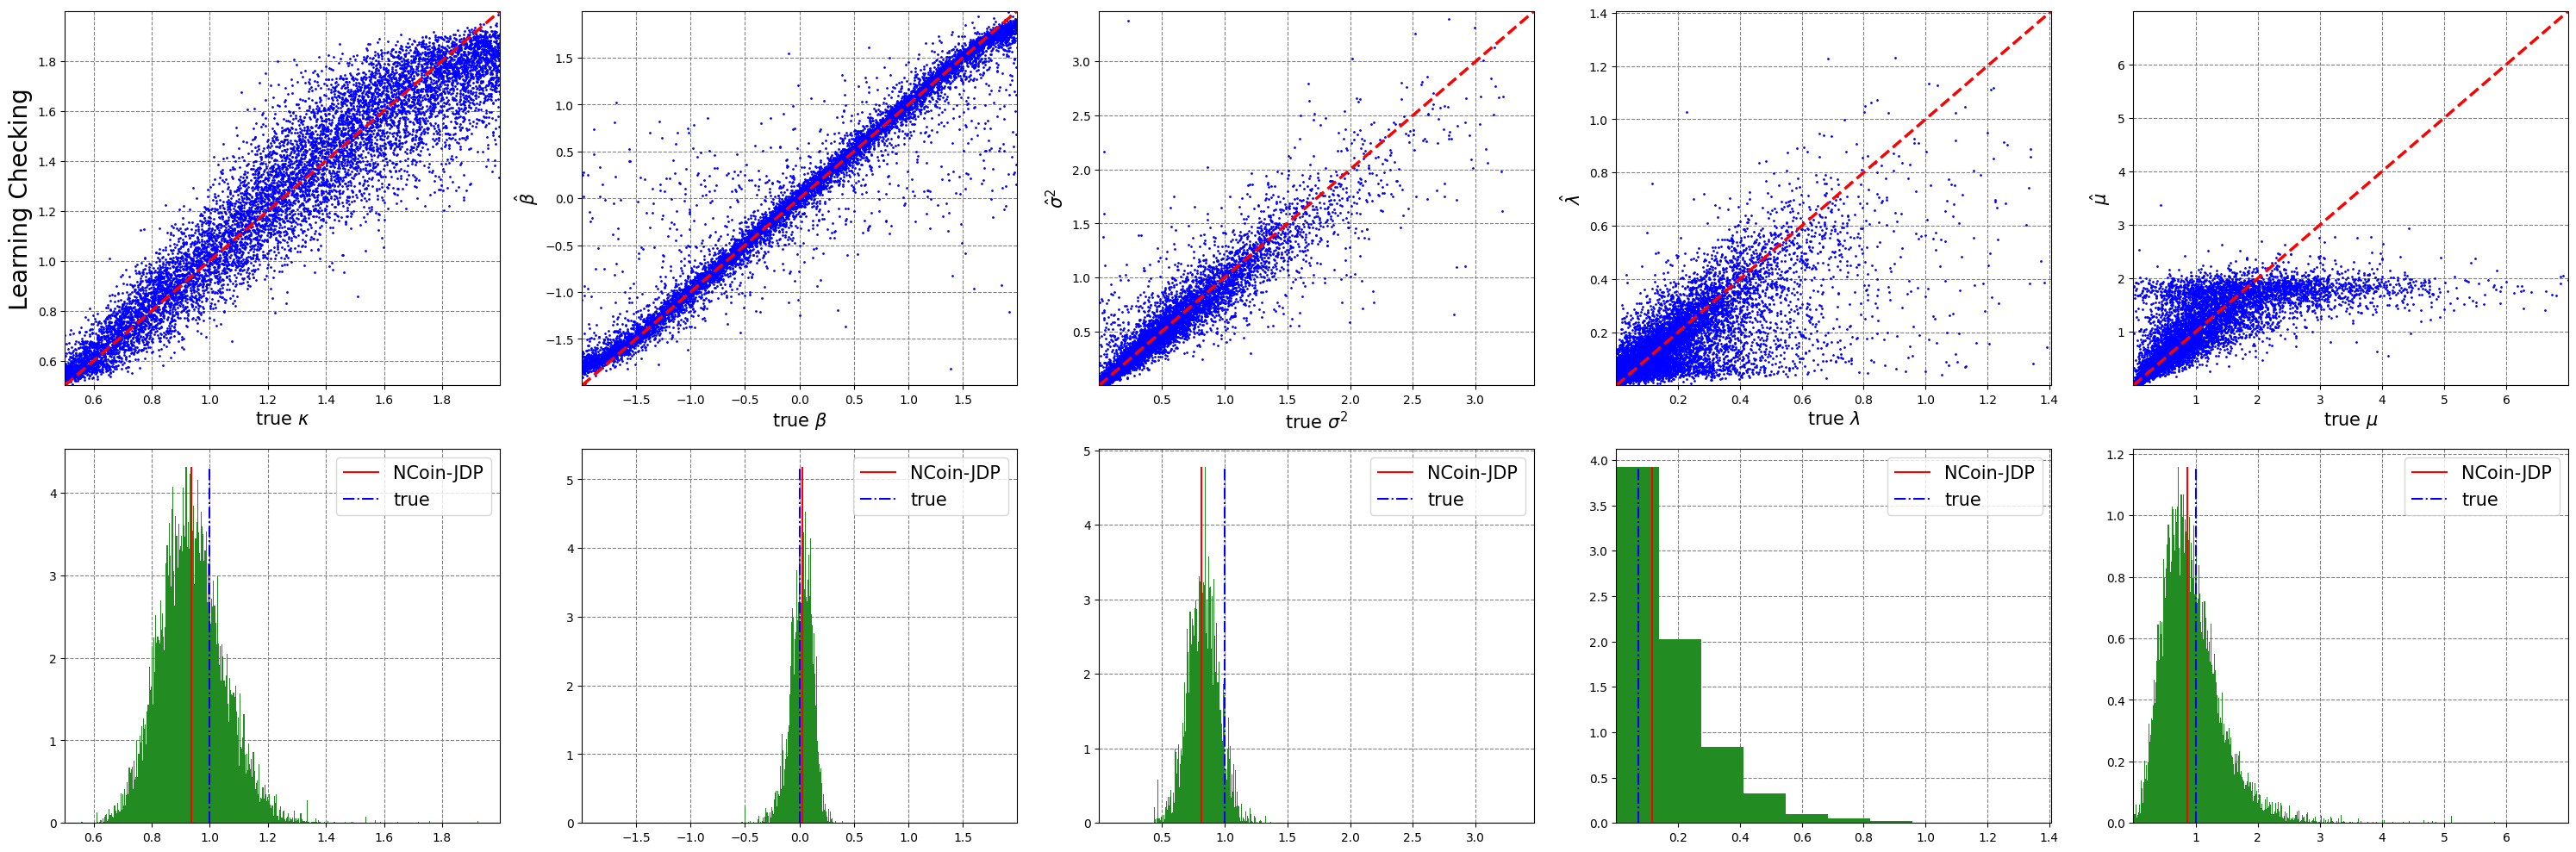

In [48]:
import matplotlib.pyplot as plt
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}^2$',  r'$\hat{\lambda}$', r'$\hat{\mu}$']

#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']
true_param = [1, 0, 1, 0.07, 1]

exp_ind = [3, 4]

# First sample
est = net(obs).detach()[0]
weights = np.copy(results5[0].detach().cpu().numpy())    
samples = np.copy(results5[1].detach().cpu().numpy())

for j in exp_ind:
    est[j] = np.exp(est[j])
    samples[:,j] = np.exp(samples[:,j])

with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking
lim_left = torch.quantile(output,.001, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.999, 0).detach().cpu().numpy()

for i in exp_ind:
    lim_left[i] = np.exp(lim_left[i])
    lim_right[i] = np.exp(lim_right[i])


fig, axs = plt.subplots(2, len(tmp[0]), figsize=(30,10))


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    if i in exp_ind:
        axs[0, i].scatter(torch.exp(y_test[:,i]), np.exp(tmp1), marker='o', color='b', s= 1)
    else:
        axs[0, i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    axs[0,0].set_ylabel("Learning Checking", fontsize = 20)


for i in range(len(true_name)):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    #if i in exp_ind:
    #    lim0 = np.exp(lim0); lim1 = np.exp(lim1)
    y, x, _ = axs[1,i].hist(samples[:,i], density=True, weights = weights, bins = 1000, color = "forestgreen")
    axs[1, i].set_axisbelow(True)
    axs[1, i].grid(color='gray', linestyle='dashed')
    axs[1, i].set_xlim([lim0, lim1])
    axs[1, i].vlines(est[i], 0, max(y), color = 'red')
    axs[1, i].vlines(true_param[i], 0, max(y), color = 'blue', linestyle ="dashdot")
    axs[1, i].legend(['NCoin-JDP', 'true'], loc = "upper right", fontsize=15) 
fig.tight_layout()
#fig.savefig("../JD_plots/OUJ_infer.pdf") 

In [20]:
true_param = [1, 0, 1, 0.07, 1]
results_list = torch.load("./results/Comparison2_infer.pt")
print(len(results_list))
exp_ind = [3, 4]
size = 100000

sam = []
for j in range(len(true_param)):
    sam_1 = []
    for i in range(len(results_list)):
        results = results_list[i]
        samples_1 = []
        if j in exp_ind:
            samples_1.append(np.exp(results[1][:,j].detach().cpu().numpy()))
        else:
            samples_1.append(results[1][:,j].detach().cpu().numpy())
        vec = samples_1[0]
        
        np.random.seed(1)
        weights = np.copy(results[0].detach().cpu().numpy())
        P = weights/weights.sum()
        
        sam_2 = np.random.choice(vec,size,replace=True, p=P)
        sam_1.append(sam_2)
    sam.append(sam_1)

3


In [22]:
for j in range(len(true_param)):
    tmp = np.concatenate(sam[j])
    if j == 2:
        tmp = np.sqrt(np.abs(tmp))
    hpd_source = hpd_grid(tmp, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", tmp.mean(), "med: ", np.median(tmp),
          "sd: ",tmp.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_8329/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.74421, 1.14451)] mean:  0.94016135 med:  0.9334893 sd:  0.10329044 mod:  [0.91248]
interval:  [(-0.18947, 0.20677)] mean:  0.01789855 med:  0.028052263 sd:  0.10355585 mod:  [0.05687]
interval:  [(0.75709, 1.05125)] mean:  0.9070109 med:  0.90963864 sd:  0.07388253 mod:  [0.92248]
interval:  [(0.0, 0.49783)] mean:  0.17870544 med:  0.12869963 sd:  0.17219123 mod:  [0.04979]
interval:  [(0.13075, 1.84964)] mean:  0.9471129 med:  0.8743414 sd:  0.48956913 mod:  [0.80964]


In [49]:
size = 200000
P = weights/weights.sum()

for j in range(5):
    vec = samples[:,j]
    np.random.seed(1)
    sam = np.random.choice(vec,size,replace=True, p=P)
    if j == 2:
        sam = np.sqrt(sam)
    hpd_source = hpd_grid(sam, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", sam.mean(), "med: ", np.median(sam),
          "sd: ",sam.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_109543/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.72137, 1.16297)] mean:  0.9404964 med:  0.9343942 sd:  0.11368114 mod:  [0.92009]
interval:  [(-0.18573, 0.20942)] mean:  0.01857858 med:  0.028783718 sd:  0.104100354 mod:  [0.04387]
interval:  [(0.7714, 1.04483)] mean:  0.90864915 med:  0.91106087 sd:  0.068499826 mod:  [0.91648]
interval:  [(2e-05, 0.45927)] mean:  0.16964936 med:  0.12599939 sd:  0.15281314 mod:  [0.05279]
interval:  [(0.13913, 1.92626)] mean:  0.9572722 med:  0.87389946 sd:  0.500939 mod:  [0.72127]


In [48]:
for j in range(4):
    print(est[j])
    print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))

tensor(0.9851)
[0.8175007  1.15402313]
tensor(0.1307)
[0.03114354 0.22735427]
tensor(0.0440)
[0.01725465 0.10237775]
tensor(0.7791)
[0.41995427 1.25866744]


In [ ]:
for j in range(4):
    print(est[j])
    print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))

In [ ]:
for j in range(4):
    print(est[j])
    print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))

In [ ]:
print(1.152 - 0.872, 0.188 + 0.014, 0.111 - 0.013, 1.131 - 0.396)

In [ ]:
for j in range(4):
    #print(est[j])
    tmp = weighted_quantile(samples[:,j], [0.025, 0.975], weights)
    #print(weighted_quantile(samples[:,j], [0.025, 0.975], weights))
    print(tmp[1] - tmp[0])

In [20]:
sim_num = 5000
y0 = 0 * torch.ones(sim_num)
kappa_sim = 1 * torch.ones(sim_num)
beta_sim = 0 * torch.ones(sim_num)
sigma2_sim = 1 * torch.ones(sim_num)

lambda_sim = 0.07 * torch.ones(sim_num)
mu_sim = 1 * torch.ones(sim_num)
mod_check = MROUJ_simul_sample(obtime, 1000, y0, kappa_sim, beta_sim, sigma2_sim, lambda_sim, mu_sim)

In [21]:
mod_summary = MROUJ_summary(mod_check)
mod_summary.size()

mod_summary = torch.clone((mod_summary - a) / (b - a))

print(torch.mean(net(mod_summary),0)[0:3])
print(torch.std(net(mod_summary),0)[0:3])

print(torch.mean(torch.exp(net(mod_summary)),0)[3:6])
print(torch.std(torch.exp(net(mod_summary)),0)[3:6])

tensor([ 1.0497, -0.0333,  1.0351], grad_fn=<SliceBackward0>)
tensor([0.1322, 0.0605, 0.1260], grad_fn=<SliceBackward0>)
tensor([0.0959, 1.2082], grad_fn=<SliceBackward0>)
tensor([0.0495, 0.1466], grad_fn=<SliceBackward0>)
